This notebook is part of the AI Engineer Track Challenge for Digital Product School. Please see the repository at https://github.com/diksha-shrivastava13/Traffic-Accidents-Model
This notebook contains the models.

# The Necessary Imports, Loading Data and W&B Configuration

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

# NumPy and SciPy
from numpy.random import normal, seed
from scipy.stats import norm

# Scikit-Learn
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Meta Prophet
from prophet import Prophet

### Configuring wandb for the notebook.

In [2]:
# setting up wandb integration
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api")
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# extract the latest version of the dataset from W&B
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
artifact = run.use_artifact("preprocessed_dataset:latest")
artifact_dir = artifact.download()
df = pd.read_csv("/kaggle/working/artifacts/preprocessed_dataset:v1/preprocessed_dataset.csv")
wandb.finish()

wandb: Currently logged in as: diksha-shrivastava13. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231205_115151-xmd62ux6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run upbeat-breeze-52
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/xmd62ux6
wandb:   1 of 1 files downloaded.  
wandb:                                                                                
wandb: 🚀 View run upbeat-breeze-52 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/xmd62ux6
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231205_115151-xmd62ux6/logs


### Heading Towards Train Test Split

In [4]:
df.head()

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2020,1,28.0,2020-01-01,1,0,0,0,1,0
1,2020,2,40.0,2020-02-01,1,0,0,0,1,0
2,2020,3,27.0,2020-03-01,1,0,0,0,1,0
3,2020,4,26.0,2020-04-01,1,0,0,0,1,0
4,2020,5,40.0,2020-05-01,1,0,0,0,1,0


In [5]:
df.shape

(1764, 10)

In [6]:
df_sorted = df.sort_values(by='Date')
train_percentage = 0.8
split_index = int(len(df_sorted) * train_percentage)
train_set = df_sorted[:split_index]
test_set = df_sorted[split_index:]
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [7]:
train_set

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2000,1,34.0,2000-01-01,0,1,0,1,0,0
1,2000,1,321.0,2000-01-01,0,0,1,0,0,1
2,2000,1,78.0,2000-01-01,1,0,0,0,1,0
3,2000,1,835.0,2000-01-01,0,1,0,0,1,0
4,2000,1,3448.0,2000-01-01,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1406,2016,9,4289.0,2016-09-01,0,0,1,0,1,0
1407,2016,10,448.0,2016-10-01,0,0,1,0,0,1
1408,2016,10,1022.0,2016-10-01,0,1,0,0,1,0
1409,2016,10,11.0,2016-10-01,1,0,0,1,0,0


In [8]:
test_set

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2016,10,44.0,2016-10-01,0,1,0,1,0,0
1,2016,10,30.0,2016-10-01,1,0,0,0,1,0
2,2016,10,559.0,2016-10-01,0,0,1,1,0,0
3,2016,11,489.0,2016-11-01,0,0,1,1,0,0
4,2016,11,7.0,2016-11-01,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
348,2020,12,33.0,2020-12-01,0,1,0,1,0,0
349,2020,12,311.0,2020-12-01,0,0,1,1,0,0
350,2020,12,2661.0,2020-12-01,0,0,1,0,1,0
351,2020,12,13.0,2020-12-01,1,0,0,0,1,0


In [9]:
X_train, y_train = train_set.drop(columns=["Date", "VALUE"]), train_set["VALUE"]
X_test, y_test = test_set.drop(columns=["Date", "VALUE"]), test_set["VALUE"]

In [10]:
np.array(X_train)[0]

array([2000,    1,    0,    1,    0,    1,    0,    0])

In [11]:
np.array(y_train)[0]

34.0

# Linear Regression Model

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_train, y_train)

0.7265788183932369

In [13]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression RMSE: {rmse}")

# Calculate R2 Score
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression R2 Score: {r2}")

Linear Regression RMSE: 653.1732043759321
Linear Regression R2 Score: 0.7170236363575042


In [14]:
print(y_test[0], y_pred[0])

44.0 -115.70965443127625


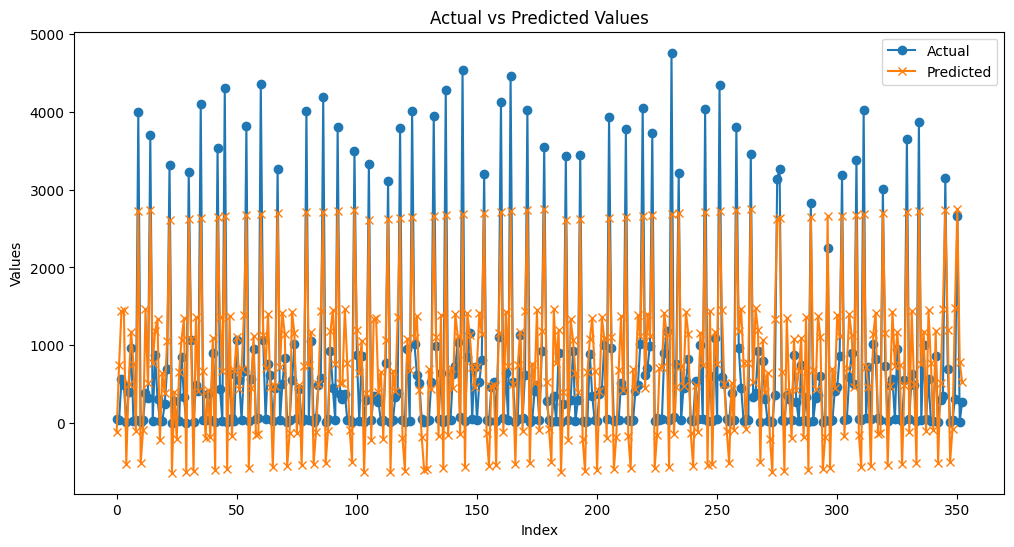

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Poisson Regression Model

In [16]:
# Fit Poisson Regression model
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Predict on the test set
y_pred = poisson_model.predict(X_test)

# Evaluate the model
mse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(poisson_model.summary())

Root Mean Squared Error: 216.21661476456651
R-squared: 0.9689921561556517
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  VALUE   No. Observations:                 1411
Model:                            GLM   Df Residuals:                     1404
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29120.
Date:                Tue, 05 Dec 2023   Deviance:                       48083.
Time:                        11:52:48   Pearson chi2:                 4.97e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [17]:
print(y_test[0], y_pred[0])

44.0 114.80643060348815


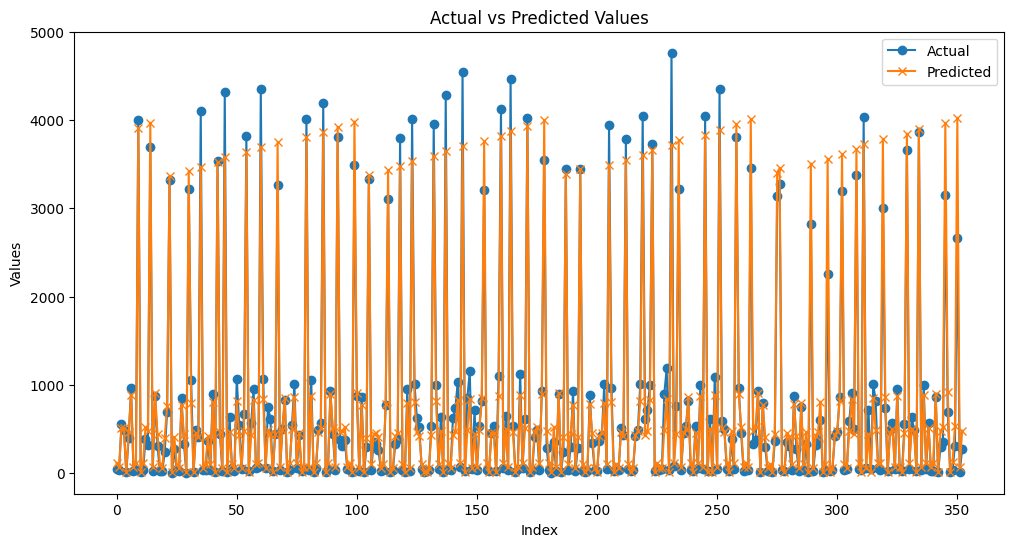

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Multi-Layer Perceptron Regressor

In [19]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Fit the model
mlp_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp_regressor.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 1227.4699
R-squared (R2) Score: 0.0007


In [20]:
print(y_test[0], y_pred[0])

44.0 809.1365259668698


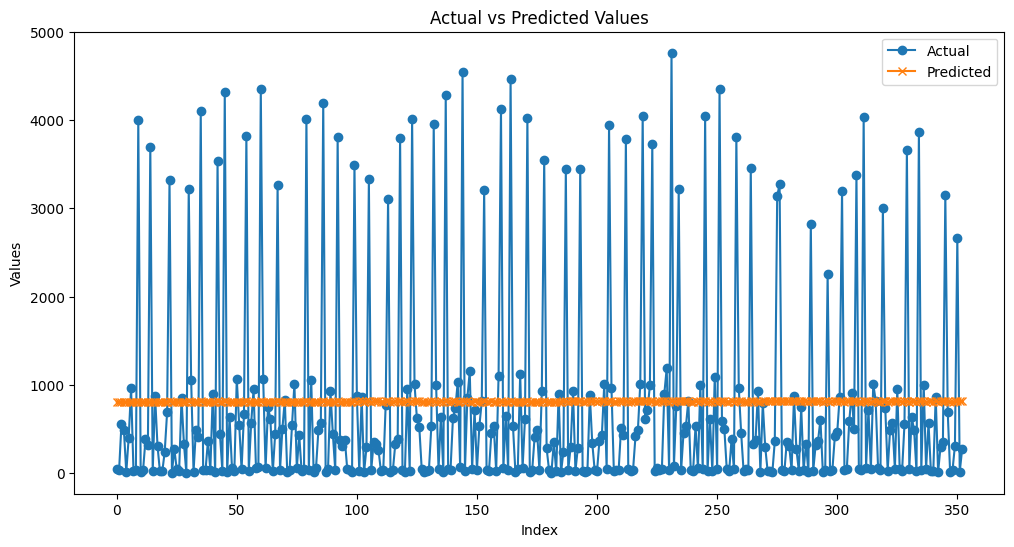

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# XGBoost

In [22]:
from xgboost import XGBRegressor as xgb
import joblib

model = XGBRegressor(
    max_depth=5,
    n_estimators=415,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse",  
    verbose=True)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 179.7718
R-squared (R2) Score: 0.9786


### BentoML Checks

In [23]:
model.save_model('model_file_name.json')

In [24]:
model = xgb()
model.load_model("model_file_name.json")

In [25]:
!pip install bentoml

  Obtaining dependency information for bentoml from https://files.pythonhosted.org/packages/fc/50/5a1e031d4f664724ee0583b0cca18f483b908eda53dfed41a8506f732290/bentoml-1.1.10-py3-none-any.whl.metadata
  Obtaining dependency information for cattrs<23.2.0,>=22.1.0 from https://files.pythonhosted.org/packages/3a/ba/05df14efaa0624fac6b1510e87f5ce446208d2f6ce50270a89b6268aebfe/cattrs-23.1.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 4.2 MB/s eta 0:00:00
  Obtaining dependency information for click-option-group from https://files.pythonhosted.org/packages/af/75/81ea958bc0f7e410257cb2a42531b93a7695a31930cde87192c010a52c50/click_option_group-0.5.6-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 13.4 MB/s eta 0:00:00
  Obtaining dependency information for httpx from https://files.pythonhosted.org/packages/a2/65/6940eeb21dcb2953778a6895281c179efd9100463ff08cb6232bb6480da7/httpx-0.25.2-py3-none-any.whl.metadata
  Obtai

In [26]:
import bentoml
bento_model = bentoml.xgboost.save_model("my_xgboost_model", model)

In [27]:
loaded_model = bentoml.xgboost.load_model("my_xgboost_model")

In [28]:
loaded_model.predict([[2000,    1,    0,    1,    0,    1,    0,    0]])

array([30.63438], dtype=float32)

In [29]:
loaded_model.predict([[2021,    10,    0,    0,    1,    1,    0,    0]])

array([635.8414], dtype=float32)

In [30]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'int',
                            'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

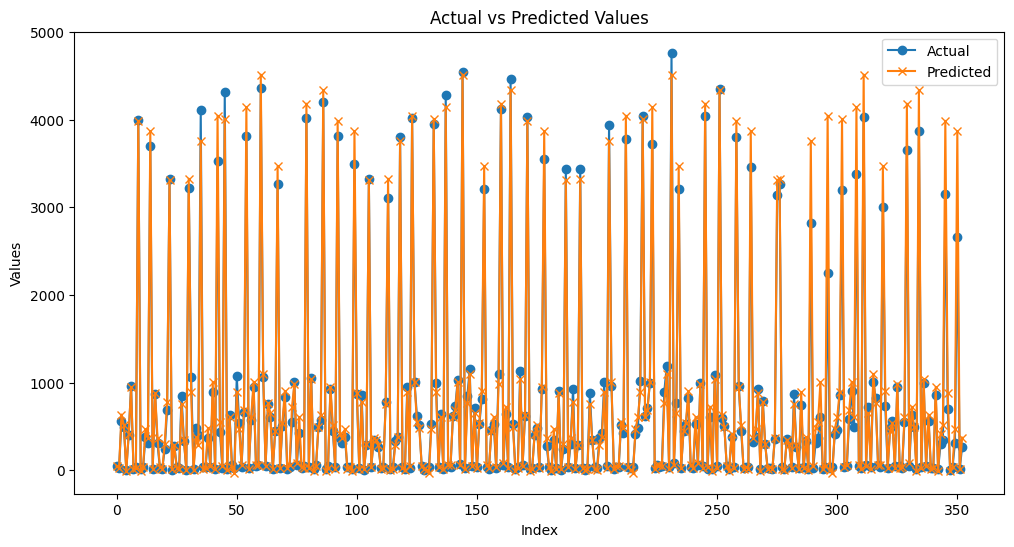

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# LightGBM Model

In [32]:
import lightgbm as lgb

In [33]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # You can use other metrics like 'mse', 'mae', etc.
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=20)

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 1411, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 775.080085
[1]	valid_0's rmse: 1164.92
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 1110.88
[3]	valid_0's rmse: 1053.69
[4]	valid_0's rmse: 1005.04
[5]	valid_0's rmse: 953.29
[6]	valid_0's rmse: 904.256
[7]	valid_0's rmse: 857.761
[8]	valid_0's rmse: 813.63
[9]	valid_0's rmse: 771.884
[10]	valid_0's rmse: 732.198
[11]	valid_0's rmse: 694.781
[12]	valid_0's rmse: 662.951
[13]	valid_0's rmse: 632.821
[14]	v

In [34]:
print(y_test[70], y_pred[70])

831.0 939.4613818226185


In [35]:
y_pred_train = bst.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 115.5612
R-squared (R2) Score: 0.9902


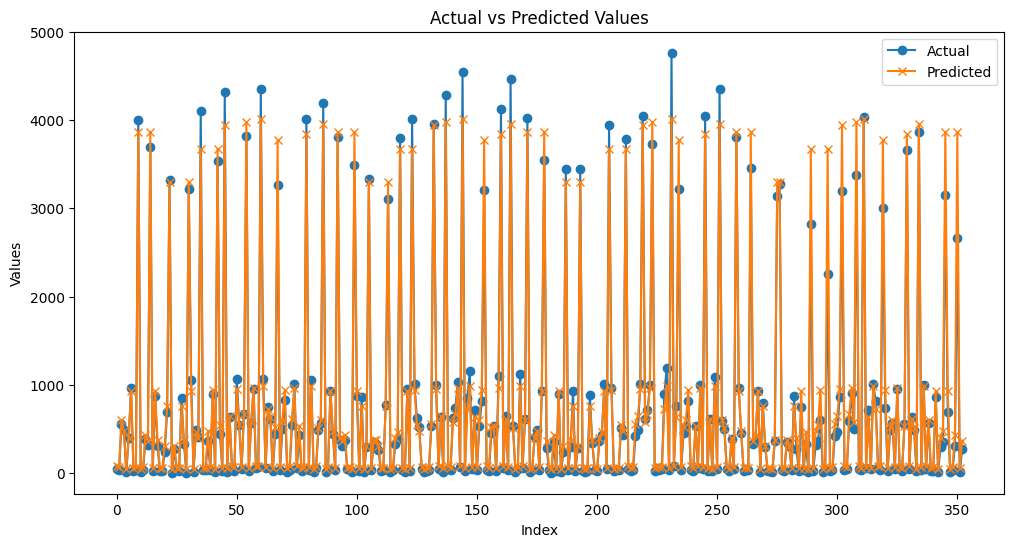

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# KFold Validation on XGBoost

In [37]:
X = df.drop(columns=["Date", "VALUE"])
y = df["VALUE"]

In [38]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have your features and target variable in X and y

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Squared Error as the evaluation metric
    'max_depth': 5,  # Maximum depth of each tree
    'learning_rate': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training instance
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'seed': 42
}

# Specify the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
rmse_scores = []
r2_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create XGBoost DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate and store evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Print average scores across all folds
print(f'Average RMSE across {num_folds} folds: {np.mean(rmse_scores)}')
print(f'Average R2 score across {num_folds} folds: {np.mean(r2_scores)}')
print(r2_scores)


Average RMSE across 5 folds: 95.62774959473077
Average R2 score across 5 folds: 0.9933627767925461
[0.992426874745892, 0.9937096086301925, 0.993859962757368, 0.9919399852011958, 0.9948774526280827]


# Prophet Models

### Some Preprocessing Steps

In [39]:
# extract the latest version of the dataset from W&B
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
artifact = run.use_artifact("dataset:latest")
artifact_dir = artifact.download()
df = pd.read_csv(f"{artifact_dir}/translated_dataset.csv")
wandb.finish()

wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231205_115319-8xch84a3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run flowing-oath-53
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/8xch84a3
wandb:   1 of 1 files downloaded.  
wandb:                                                                                
wandb: 🚀 View run flowing-oath-53 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/8xch84a3
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231205_115319-8xch84a3/logs


In [40]:
df.head()

,Month Count,CHARACTERISTIC,YEAR,MONTH,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
0,Alcohol Accidents,total,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alcohol Accidents,total,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alcohol Accidents,total,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alcohol Accidents,total,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alcohol Accidents,total,2023,202305,NaN,NaN,NaN,NaN,NaN


In [41]:
df.dtypes

Month Count                          object
CHARACTERISTIC                       object
YEAR                                  int64
MONTH                                 int64
VALUE                               float64
PREVIOUS YEAR'S VALUE               float64
Change Previous Month Percentage    float64
Change Previous Year's Month        float64
TWELVE_MONTHS_MEAN                  float64
dtype: object

In [42]:
df['MONTH'] = df['MONTH'] % 100
df['ds'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)
df.rename(columns={'VALUE': 'y'}, inplace=True)

In [43]:
df.head()

,Month Count,CHARACTERISTIC,y,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN,ds
0,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-01-01
1,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-02-01
2,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-03-01
3,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-04-01
4,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-05-01


In [44]:
df.dtypes

Month Count                                 object
CHARACTERISTIC                              object
y                                          float64
PREVIOUS YEAR'S VALUE                      float64
Change Previous Month Percentage           float64
Change Previous Year's Month               float64
TWELVE_MONTHS_MEAN                         float64
ds                                  datetime64[ns]
dtype: object

In [45]:
df = df.drop(columns=["PREVIOUS YEAR'S VALUE", 'Change Previous Month Percentage', "Change Previous Year's Month", 'TWELVE_MONTHS_MEAN'])
df = df[df['ds'].dt.year <= 2020]
df['Month Count'] = df['Month Count'].replace({'Accidents, Traffic': 'Traffic Accidents'})
df = df.sort_values(by='ds')

In [46]:
df.head()

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
276,Alcohol Accidents,total,78.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01


In [47]:
df_alcohol = df[df['Month Count'] == "Alcohol Accidents"]
df_escape = df[df['Month Count'] == "Escape accidents"]
df_traffic = df[df['Month Count'] == "Traffic Accidents"]

In [48]:
df_traffic

,Month Count,CHARACTERISTIC,y,ds
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01
2004,Traffic Accidents,Injured and killed,434.0,2000-01-01
1717,Traffic Accidents,with personal injury,329.0,2000-02-01
1429,Traffic Accidents,total,3181.0,2000-02-01
...,...,...,...,...
1774,Traffic Accidents,Injured and killed,348.0,2020-11-01
1198,Traffic Accidents,total,3150.0,2020-11-01
1775,Traffic Accidents,Injured and killed,311.0,2020-12-01
1199,Traffic Accidents,total,2661.0,2020-12-01


In [49]:
df_escape

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1141,Escape accidents,Injured and killed,35.0,2000-02-01
853,Escape accidents,total,890.0,2000-02-01
1142,Escape accidents,Injured and killed,48.0,2000-03-01
...,...,...,...,...
909,Escape accidents,Injured and killed,50.0,2020-10-01
910,Escape accidents,Injured and killed,27.0,2020-11-01
622,Escape accidents,total,864.0,2020-11-01
623,Escape accidents,total,694.0,2020-12-01


In [50]:
df_alcohol

,Month Count,CHARACTERISTIC,y,ds
276,Alcohol Accidents,total,78.0,2000-01-01
564,Alcohol Accidents,Injured and killed,37.0,2000-01-01
277,Alcohol Accidents,total,53.0,2000-02-01
565,Alcohol Accidents,Injured and killed,19.0,2000-02-01
278,Alcohol Accidents,total,73.0,2000-03-01
...,...,...,...,...
45,Alcohol Accidents,total,34.0,2020-10-01
46,Alcohol Accidents,total,23.0,2020-11-01
334,Alcohol Accidents,Injured and killed,11.0,2020-11-01
335,Alcohol Accidents,Injured and killed,9.0,2020-12-01


### Alcohol Model

In [51]:
model_alcohol = Prophet()
model_alcohol.fit(df_alcohol)

11:54:17 - cmdstanpy - INFO - Chain [1] start processing
11:54:17 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
future_alcohol = model_alcohol.make_future_dataframe(periods=12, freq='30d')
forecast = model_alcohol.predict(future_alcohol)

In [53]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,53.420178,25.496168,62.106253,53.420178,53.420178,-9.373007,-9.373007,-9.373007,-9.373007,-9.373007,-9.373007,0.0,0.0,0.0,44.047171
1,2000-02-01,53.195907,24.219969,61.500735,53.195907,53.195907,-11.030748,-11.030748,-11.030748,-11.030748,-11.030748,-11.030748,0.0,0.0,0.0,42.165159
2,2000-03-01,52.986105,27.634068,63.426424,52.986105,52.986105,-7.514685,-7.514685,-7.514685,-7.514685,-7.514685,-7.514685,0.0,0.0,0.0,45.471421
3,2000-04-01,52.761834,31.150771,68.366432,52.761834,52.761834,-3.765715,-3.765715,-3.765715,-3.765715,-3.765715,-3.765715,0.0,0.0,0.0,48.996120
4,2000-05-01,52.544798,41.455297,77.537803,52.544798,52.544798,6.637874,6.637874,6.637874,6.637874,6.637874,6.637874,0.0,0.0,0.0,59.182672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-07-29,23.984763,9.270057,45.743492,23.943906,24.017894,3.122722,3.122722,3.122722,3.122722,3.122722,3.122722,0.0,0.0,0.0,27.107486
260,2021-08-28,23.978500,14.973608,51.270012,23.926577,24.021467,7.828636,7.828636,7.828636,7.828636,7.828636,7.828636,0.0,0.0,0.0,31.807135
261,2021-09-27,23.972236,10.180397,45.275450,23.908802,24.028268,4.328134,4.328134,4.328134,4.328134,4.328134,4.328134,0.0,0.0,0.0,28.300370
262,2021-10-27,23.965972,10.412334,43.699805,23.887699,24.030033,3.478389,3.478389,3.478389,3.478389,3.478389,3.478389,0.0,0.0,0.0,27.444362


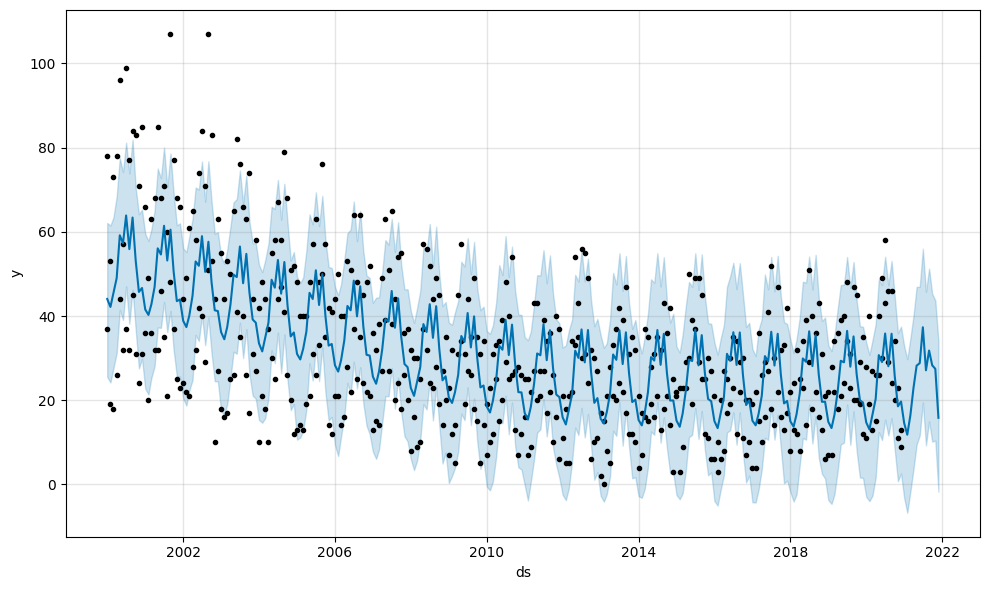

In [54]:
fig_alcohol = model_alcohol.plot(forecast)

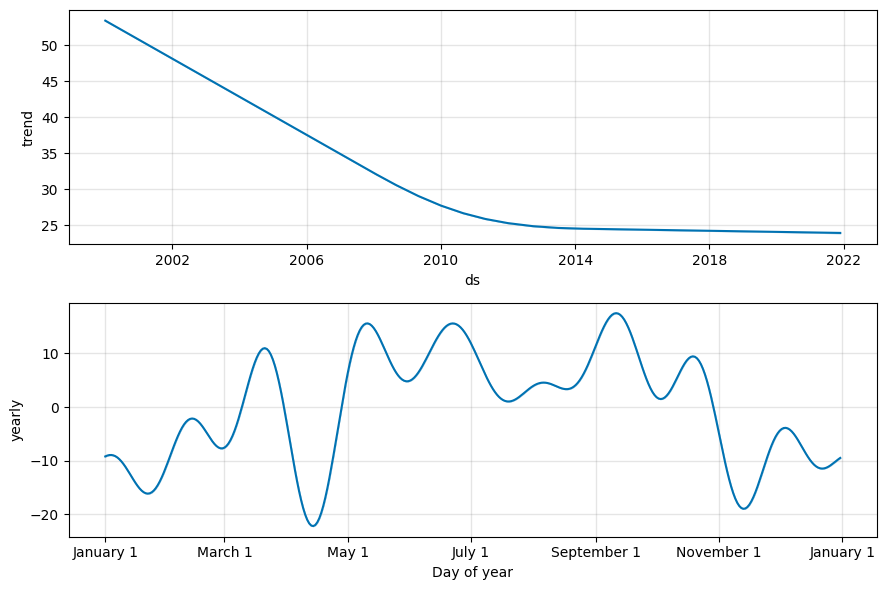

In [55]:
fig2 = model_alcohol.plot_components(forecast)

In [56]:
import pickle
with open('model_alcohol.pkl', 'wb') as model_file:
    pickle.dump(model_alcohol, model_file)

## Escape Model

In [57]:
df_escape.describe()

,y,ds
count,504.000000,504
mean,462.158730,2010-06-16 14:17:08.571428608
min,17.000000,2000-01-01 00:00:00
25%,43.000000,2005-03-24 06:00:00
50%,248.000000,2010-06-16 00:00:00
75%,876.250000,2015-09-08 12:00:00
max,1187.000000,2020-12-01 00:00:00
std,428.597712,NaN


In [58]:
model_escape = Prophet()
model_escape.fit(df_escape)

11:54:21 - cmdstanpy - INFO - Chain [1] start processing
11:54:21 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
future_escape = model_escape.make_future_dataframe(periods=12, freq="30d")
forecast_escape = model_escape.predict(future_escape)

In [60]:
forecast_escape

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,429.678569,-184.549733,865.577082,429.678569,429.678569,-65.249867,-65.249867,-65.249867,-65.249867,-65.249867,-65.249867,0.0,0.0,0.0,364.428702
1,2000-02-01,429.908257,-192.371977,911.784682,429.908257,429.908257,-61.533410,-61.533410,-61.533410,-61.533410,-61.533410,-61.533410,0.0,0.0,0.0,368.374847
2,2000-03-01,430.123127,-164.108920,965.802399,430.123127,430.123127,0.167705,0.167705,0.167705,0.167705,0.167705,0.167705,0.0,0.0,0.0,430.290833
3,2000-04-01,430.352816,-97.211817,970.629312,430.352816,430.352816,-0.419314,-0.419314,-0.419314,-0.419314,-0.419314,-0.419314,0.0,0.0,0.0,429.933501
4,2000-05-01,430.575095,-69.172823,971.815072,430.575095,430.575095,13.063017,13.063017,13.063017,13.063017,13.063017,13.063017,0.0,0.0,0.0,443.638112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-07-29,488.063904,-83.606947,1030.851320,488.063904,488.063904,-36.693508,-36.693508,-36.693508,-36.693508,-36.693508,-36.693508,0.0,0.0,0.0,451.370396
260,2021-08-28,488.286183,-23.664071,1079.425876,488.286183,488.286184,50.613649,50.613649,50.613649,50.613649,50.613649,50.613649,0.0,0.0,0.0,538.899833
261,2021-09-27,488.508463,-3.524174,1124.995283,488.508462,488.508463,57.331019,57.331019,57.331019,57.331019,57.331019,57.331019,0.0,0.0,0.0,545.839481
262,2021-10-27,488.730742,-56.359476,1056.443059,488.730741,488.730742,-4.104960,-4.104960,-4.104960,-4.104960,-4.104960,-4.104960,0.0,0.0,0.0,484.625782


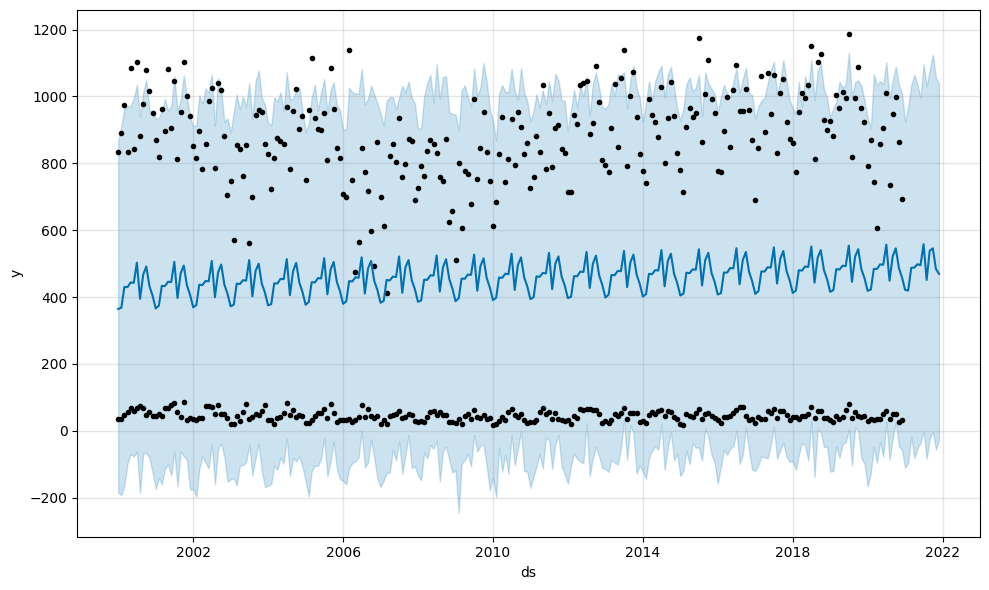

In [61]:
fig_escape = model_escape.plot(forecast_escape)

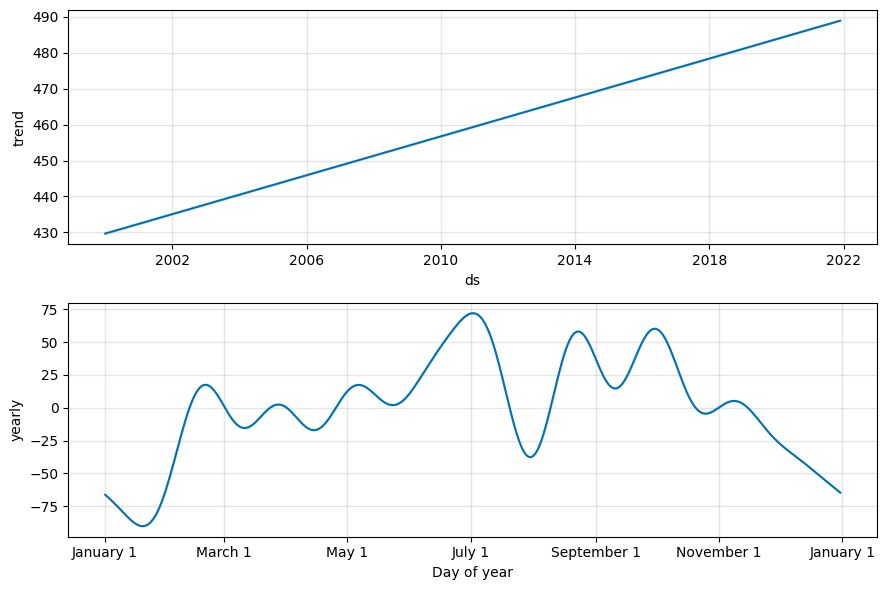

In [62]:
fig2 = model_escape.plot_components(forecast_escape)

### Traffic Accidents

In [63]:
df_traffic.describe()

,y,ds
count,756.000000,756
mean,1491.092593,2010-06-16 14:17:08.571428608
min,147.000000,2000-01-01 00:00:00
25%,414.000000,2005-03-24 06:00:00
50%,560.000000,2010-06-16 00:00:00
75%,3205.250000,2015-09-08 12:00:00
max,4763.000000,2020-12-01 00:00:00
std,1478.635750,NaN


In [64]:
model = Prophet()
model.fit(df_traffic)

11:54:24 - cmdstanpy - INFO - Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

In [66]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)

,ds,yhat,yhat_lower,yhat_upper
593,2021-11-08,1538.563779,-479.137025,3435.280737
594,2021-11-09,1533.729309,-283.205233,3526.814519
595,2021-11-10,1529.094136,-335.080687,3277.978000
596,2021-11-11,1524.751495,-350.675569,3311.230137
597,2021-11-12,1520.782480,-465.143604,3279.600344
598,2021-11-13,1517.252773,-343.214223,3314.895843
599,2021-11-14,1514.209934,-377.093236,3421.040412
600,2021-11-15,1511.681330,-322.184730,3458.473395
601,2021-11-16,1509.672797,-354.247912,3613.645490
602,2021-11-17,1508.168055,-445.932798,3297.445245


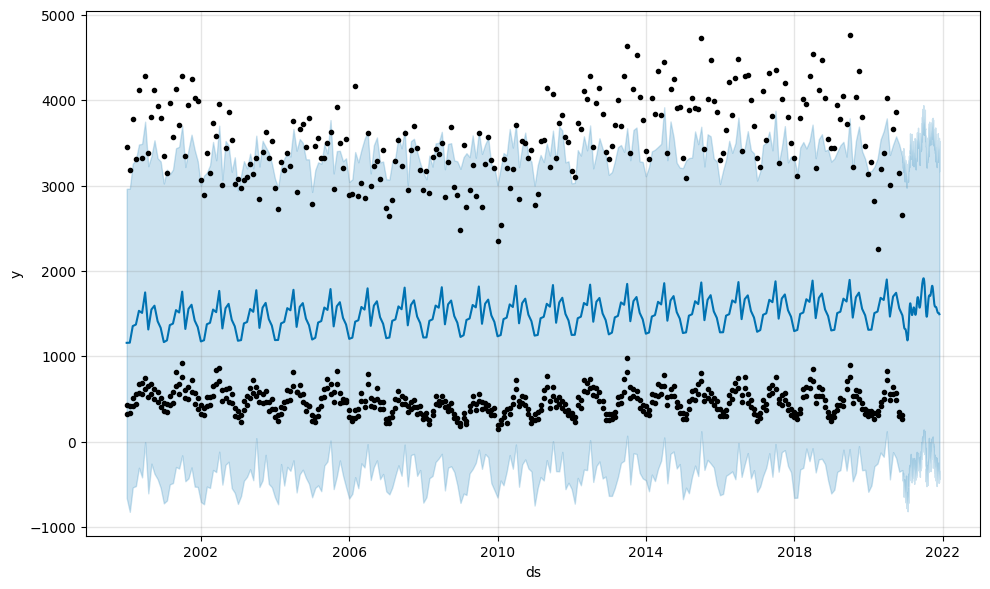

In [67]:
fig = model.plot(forecast)

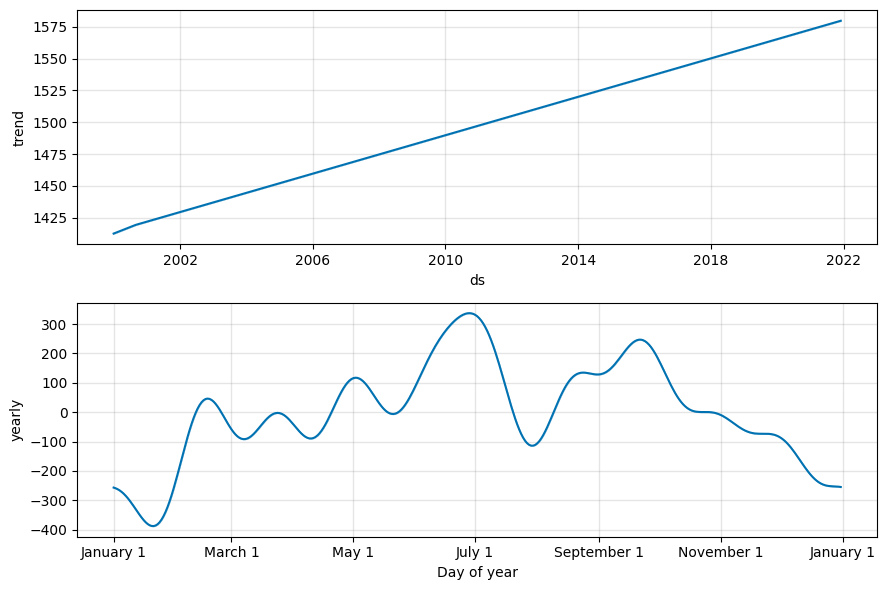

In [68]:
fig2 = model.plot_components(forecast)

# ARIMA Model

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split

In [70]:
df.head()

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
276,Alcohol Accidents,total,78.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01


In [71]:
# df.drop(columns=["ds_numeric"])

In [72]:
ts_df = df.set_index('ds')

In [73]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary? {0}'.format('No' if result[1] > 0.05 else 'Yes'))

In [74]:
# Function to plot ACF and PACF
def plot_acf_pacf(timeseries):
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    plot_acf(timeseries, lags=30, ax=ax[0])
    plot_pacf(timeseries, lags=30, ax=ax[1])
    plt.show()

In [75]:
# Function to fit ARIMA model
def fit_arima_model(timeseries, order):
    model = SARIMAX(timeseries, order=order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    return results

In [76]:
# Function to evaluate ARIMA model
def evaluate_arima_model(model, test_data):
    predictions = model.get_forecast(steps=len(test_data))
    
    # Extract numeric values from Timestamps
    predicted_mean_values = predictions.predicted_mean.values
    
    # Calculate Mean Squared Error
    mse = ((predicted_mean_values - test_data['y'].values) ** 2).mean()
    
    # Print Root Mean Squared Error
    print('Root Mean Squared Error (RMSE):', np.sqrt(mse))
    
    return predictions

In [77]:
check_stationarity(ts_df['y'])

ADF Statistic: -20.456865767486622
p-value: 0.0
Critical Values: {'1%': -3.4340794333632534, '5%': -2.863187337213453, '10%': -2.567646992971705}
Is the time series stationary? Yes


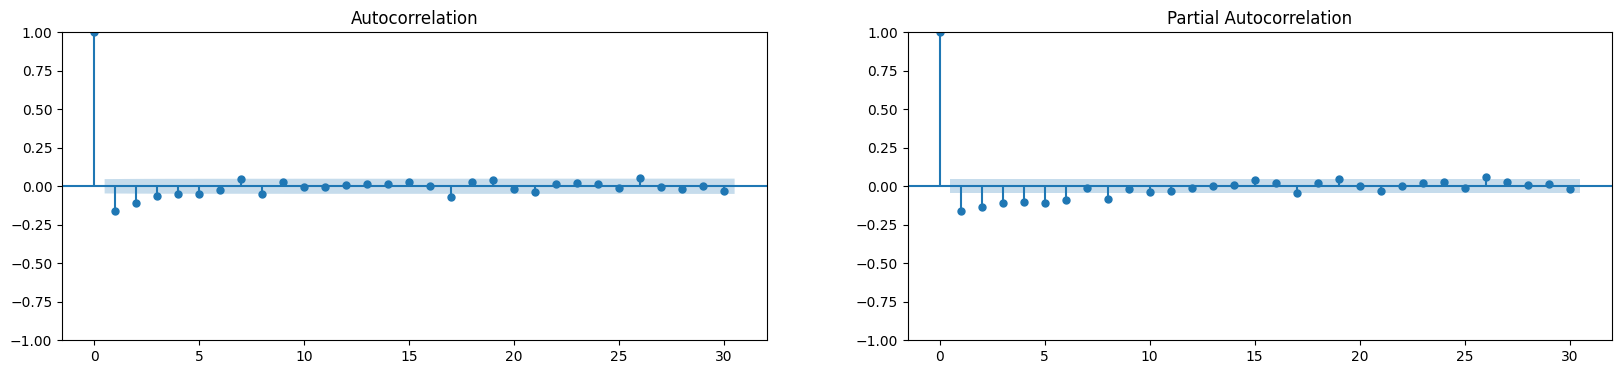

In [78]:
plot_acf_pacf(ts_df['y'])

In [79]:
train_size = int(len(ts_df) * 0.8)
train, test = ts_df.iloc[:train_size], ts_df.iloc[train_size:]

In [80]:
order = (0, 0, 0)

In [81]:
arima_model = fit_arima_model(train['y'], order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65882D+00    |proj g|=  5.05196D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.052D-07   8.659D+00
  F =   8.6588214090531217     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [82]:
arima_predictions = evaluate_arima_model(arima_model, test)

Root Mean Squared Error (RMSE): 1466.1091905585433


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
